In [2]:
# 引入Python包，在jupyter notebook 运行后可以直接输出多个变量 注意大小写
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 指定gpu设备
import os
os.environ['CUDA_VISIBLE_DEVICES'] ="0" # gpu
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # cpu

In [3]:
import shutil
import numpy as np

In [4]:
original_dataset_dir = 'kaggle-dogs-vs-cats/kaggle_original_train_data'
print('total training images:', len(os.listdir(original_dataset_dir)))

total training images: 25000


In [5]:
def mymkdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

In [6]:
base_dir = 'kaggle-dogs-vs-cats/cats_and_dogs_small'
mymkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
mymkdir(train_dir)
test_dir = os.path.join(base_dir, 'test')
mymkdir(test_dir)
validation_dir = os.path.join(base_dir, 'validation')
mymkdir(validation_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
mymkdir(train_cats_dir)
test_cats_dir = os.path.join(test_dir, 'cats')
mymkdir(test_cats_dir)
validation_cats_dir = os.path.join(validation_dir, 'cats')
mymkdir(validation_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
mymkdir(train_dogs_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
mymkdir(test_dogs_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
mymkdir(validation_dogs_dir)

In [ ]:
def copy_dataset(src_dir, dest_dir, start, end, class_name):
    rule = class_name + '.{}.jpg'
    frames = [rule.format(i) for i in range(start, end)]
    for fname in frames:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dest_dir, fname)
        shutil.copyfile(src, dst)

In [ ]:
copy_dataset(original_dataset_dir, train_cats_dir, 0, 1000, 'cat')
copy_dataset(original_dataset_dir, validation_cats_dir, 1000, 1500, 'cat')
copy_dataset(original_dataset_dir, test_cats_dir, 1500, 2000, 'cat')

copy_dataset(original_dataset_dir, train_dogs_dir, 0, 1000, 'dog')
copy_dataset(original_dataset_dir, validation_dogs_dir, 1000, 1500, 'dog')
copy_dataset(original_dataset_dir, test_dogs_dir, 1500, 2000, 'dog')

In [7]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [19]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [21]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

In [22]:
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array,array_to_img

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255) # 验证数据不能增强

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [24]:
# gpu
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100, 
    epochs=100, 
    validation_data=validation_generator, 
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 20s 196ms/step - loss: 0.6935 - acc: 0.4970 - val_loss: 0.6938 - val_acc: 0.5670
Epoch 2/100
100/100 [==============================] - 39s 393ms/step - loss: 0.6910 - acc: 0.5345 - val_loss: 0.6719 - val_acc: 0.5790
Epoch 3/100
100/100 [==============================] - 48s 485ms/step - loss: 0.6839 - acc: 0.5575 - val_loss: 0.6417 - val_acc: 0.5560
Epoch 4/100
100/100 [==============================] - 48s 485ms/step - loss: 0.6750 - acc: 0.5725 - val_loss: 0.6716 - val_acc: 0.5940
Epoch 5/100
100/100 [==============================] - 43s 433ms/step - loss: 0.6626 - acc: 0.5990 - val_loss: 0.6344 - val_acc: 0.6250
Epoch 6/100
100/100 [==============================] - 30s 301ms/step - loss: 0.6600 - acc: 0.6025 - val_loss: 0.6063 - val_acc: 0.5950
Epoch 7/100
100/100 [==============================] - 51s 513ms/step - loss: 0.6468 - acc: 0.6155 - val_loss: 0.5722 - val_acc: 0.6510
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 62s 622ms/step - loss: 0.4615 - acc: 0.7880 - val_loss: 0.3173 - val_acc: 0.7800
Epoch 62/100
100/100 [==============================] - 75s 749ms/step - loss: 0.4637 - acc: 0.7785 - val_loss: 0.6432 - val_acc: 0.7490
Epoch 63/100
100/100 [==============================] - 66s 658ms/step - loss: 0.4445 - acc: 0.7955 - val_loss: 0.4326 - val_acc: 0.7930
Epoch 64/100
100/100 [==============================] - 37s 369ms/step - loss: 0.4383 - acc: 0.7950 - val_loss: 0.3156 - val_acc: 0.8090
Epoch 65/100
100/100 [==============================] - 36s 364ms/step - loss: 0.4397 - acc: 0.7925 - val_loss: 0.5711 - val_acc: 0.7430
Epoch 66/100
100/100 [==============================] - 49s 490ms/step - loss: 0.4310 - acc: 0.7990 - val_loss: 0.6685 - val_acc: 0.7640
Epoch 67/100
100/100 [==============================] - 71s 710ms/step - loss: 0.4248 - acc: 0.8060 - val_loss: 0.2561 - val_acc: 0.7850
Epoch 68/100
100/100 [===================

In [25]:
model.save('cats_and_dogs_small_2.h5')

Text(0.5, 1.0, 'Training and validation accuracy')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

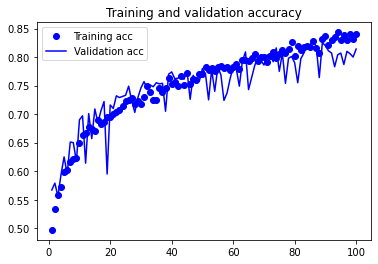

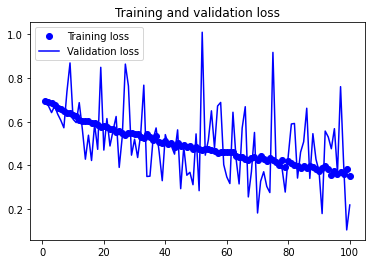

In [26]:
import matplotlib.pyplot as plt 

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
 
epochs = range(1, len(acc) + 1) 
 
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 
 
plt.figure() 
 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()

In [ ]:
# cpu 训练耗时是用gpu的3倍
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100, 
    epochs=30, 
    validation_data=validation_generator, 
    validation_steps=50)

In [ ]:
model.save('cats_and_dogs_small_1_cpu.h5')

In [ ]:
history.history.keys()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

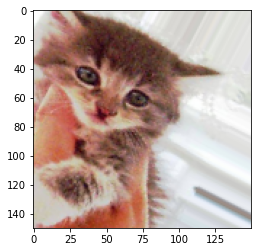

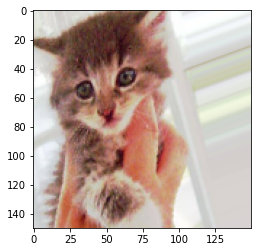

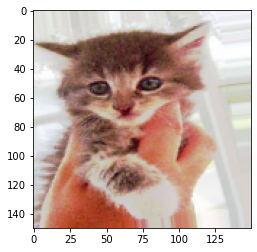

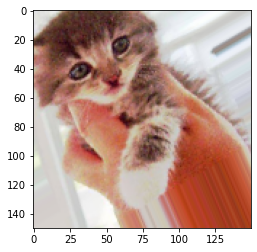

In [10]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

image_path = fnames[3]

img = image.load_img(image_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    implot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
    